# Ultimate Technologies: EDA

In [1]:
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

## Load Data
Load the logins data set to a Pandas Dataframe.

In [2]:
df = pd.read_json('./data/logins.json')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


## Exploratory Analysis
I will begin by resampling the data into 15 minute increments.

In [5]:
df_reindexed = df.set_index('login_time').copy()

In [6]:
df_reindexed['logged_in'] = 1

In [7]:
df_resampled = df_reindexed.resample('15Min').count()

In [8]:
df_resampled.head()

,logged_in
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [9]:
df_resampled.reset_index(inplace=True)

Let's plot the time series to see what it looks like.

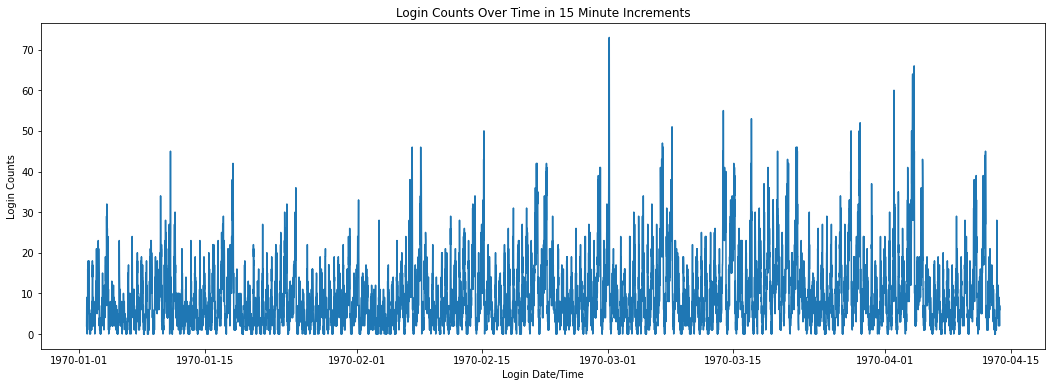

In [10]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.lineplot(x='login_time', y='logged_in', data=df_resampled, ax=ax)
ax.set_xlabel('Login Date/Time')
ax.set_ylabel('Login Counts')
ax.set_title('Login Counts Over Time in 15 Minute Increments')
plt.show()

**Obsevations:**
There apears to be some periodicity. But, there is also a lot of noise.

Let's zoom in on a one day segment and see if there are any patterns.

In [12]:
start = df_resampled['login_time'].searchsorted(datetime(1970, 3, 1))

In [13]:
end = df_resampled['login_time'].searchsorted(datetime(1970, 3, 2))

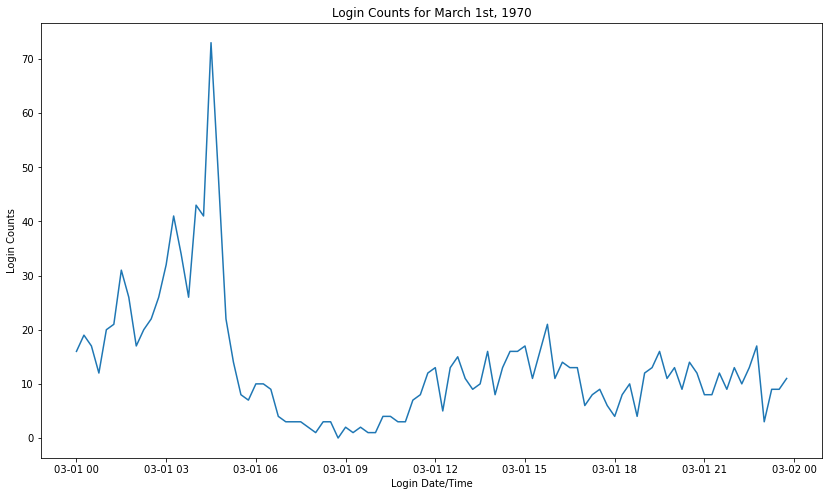

In [14]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.lineplot(x='login_time', y='logged_in', data=df_resampled.iloc[start:end], ax=ax)
ax.set_xlabel('Login Date/Time')
ax.set_ylabel('Login Counts')
ax.set_title('Login Counts for March 1st, 1970')
plt.show()

**Observations:**
* There is a sharp peak in login counts around 3 AM.
* There is a gradual increase and decrease in login couns between noon and 6 PM.


### Timeseries Decomposition
We can use `statsmodels` to decompose the timeseries into several components, which will help us learn more about it's characteristics. I will begin by considering the full timeseries.

In [80]:
decomposition = sm.tsa.seasonal_decompose(df_resampled.set_index('login_time')['logged_in'], period=int((24*60) / 15))

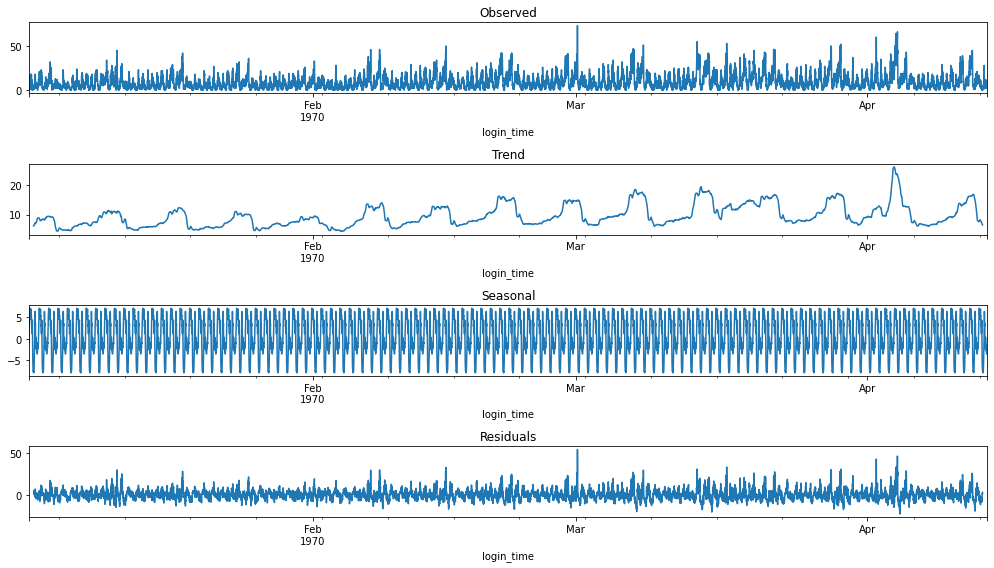

In [81]:
plot_types = ['observed', 'trend', 'seasonal', 'resid']
fig, ax = plt.subplots(4, 1, figsize=(14, 8))
decomposition.observed.plot(ax=ax[0])
ax[0].set_title('Observed')
decomposition.trend.plot(ax=ax[1])
ax[1].set_title('Trend')
decomposition.seasonal.plot(ax=ax[2])
ax[2].set_title('Seasonal')
decomposition.resid.plot(ax=ax[3])
ax[3].set_title('Residuals')
plt.tight_layout()
plt.show()

**Observations:**
* The trend shows patterns on a weekly time scale.
* There is lots of seasonality.

Let's zoom in on one week, to better understand the seasonal behavior.

In [88]:
start = df_resampled['login_time'].searchsorted(datetime(1970, 3, 1))
end = df_resampled['login_time'].searchsorted(datetime(1970, 3, 7))
df_subset = df_resampled.iloc[start:end]

In [89]:
decomposition_week = sm.tsa.seasonal_decompose(df_subset.set_index('login_time')['logged_in'], period=int((24*60) / 15))

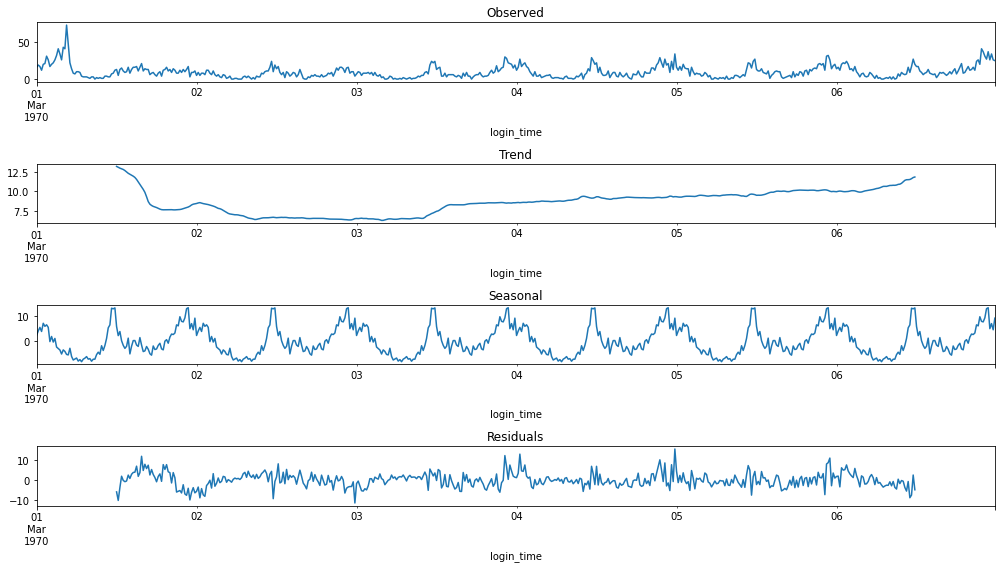

In [90]:
plot_types = ['observed', 'trend', 'seasonal', 'resid']
fig, ax = plt.subplots(4, 1, figsize=(14, 8))
decomposition_week.observed.plot(ax=ax[0])
ax[0].set_title('Observed')
decomposition_week.trend.plot(ax=ax[1])
ax[1].set_title('Trend')
decomposition_week.seasonal.plot(ax=ax[2])
ax[2].set_title('Seasonal')
decomposition_week.resid.plot(ax=ax[3])
ax[3].set_title('Residuals')
plt.tight_layout()
plt.show()

**Observations:**
* The trend peaks on Sunday, drops sharply on Tuesday, and then slowly increases towards the weekend.
* The seasonal plot shows the same daily pattern seen in the March 1st plot above.

### Autocorrelation
We can further investigate patterns by making an autocorrelation plot.

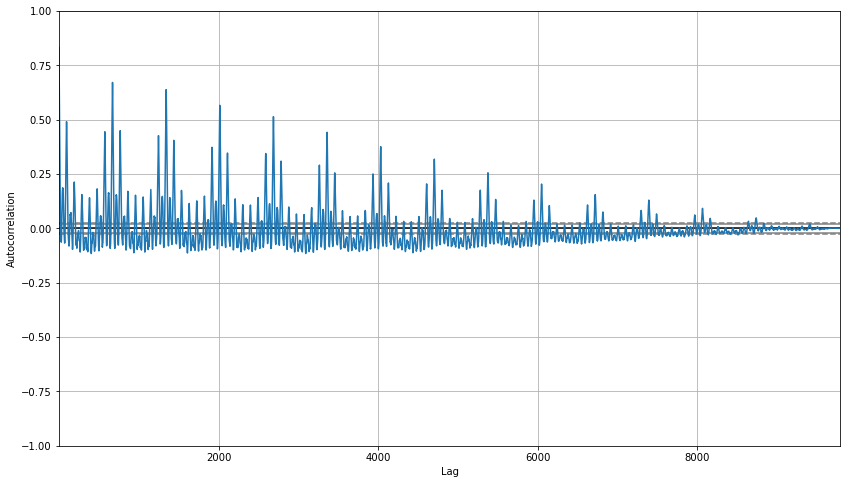

In [55]:
plt.figure(figsize=(14, 8))
pd.plotting.autocorrelation_plot(df_resampled.set_index('login_time')['logged_in'])
plt.show()

**Observations:**
The autocorrelation shows many, pominant peaks, indicating a substantial amount of periodicity in the time series.